# Style Transfer with Deep Neural Network

I'm going to implement style transfer using Pytroch in this notebook. Thanks for the Udacity Deep Learning course and [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). 

Style transfer is about to generate a fusion image by combining a content image and a style image. The objects and arrangements in the new image are recognized from the content image, while the color, texture and other styles are extracted from the style image. 

Below are two excellent illustration on what style transfer is and how amazing it is.

<img src='https://www.researchgate.net/profile/Jeremiah_Johnson18/publication/330828467/figure/fig1/AS:721849084297216@1549113641325/Two-examples-of-image-style-transfer-generated-using-the-neural-style-algorithm-of-Gatys.ppm' width=80% />

We will use a pre-trained VGG19 network to accomplish this task. We will extract the output from the second convolutional layer in the fourth stack of the network as the content representation of the image and the outputs from the first convolutional layer from all 5 stacks as the style representation because we want to include all kinds of styles features from the image.

In [1]:
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms, models
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Loading Images

We want to keep a reasonable number of parameters to learn in the training part, so we set a maxmimum size to our images. We also want to keep the size of style image same as the content image, so we give a shape argument to our function to assign the their shape to each other.

In [22]:
def load_image(image_path, shape=None, max_size=300):
    image = Image.open(image_path).convert('RGB')
    
    size = min(max(image.size), max_size)
    
    if shape is not None:
        size = shape
        
    transform = transforms.Compose([
        transforms.Resize(size),#rescale the image, the smaller edge will be equal to size, and the other edge will proportional resized. 
        transforms.ToTensor(),#convert numpy array to tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    image = transform(image).unsqueeze(0)

    return image

In [23]:
def input_images(content_path, style_path, max_size=300):
    content_image = load_image(content_path, max_size).to(device)
    style_image = load_image(style_path, shape=content_image.size()[2:]).to(device)
    return content_image, style_image

In [24]:
content_image, style_image = input_images('images/janelle.png', 'images/delaunay.jpg')

## Visualize the Images

If we would like to take a look at our images, we need to convert them from torch tensor to numpy array so that we can visualize them using matplotlib. We also did some denormalization to convert the pixel values back into range 0-1 to get rid of the previous normalization. 

In [25]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().squeeze().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    return image.clip(0, 1)

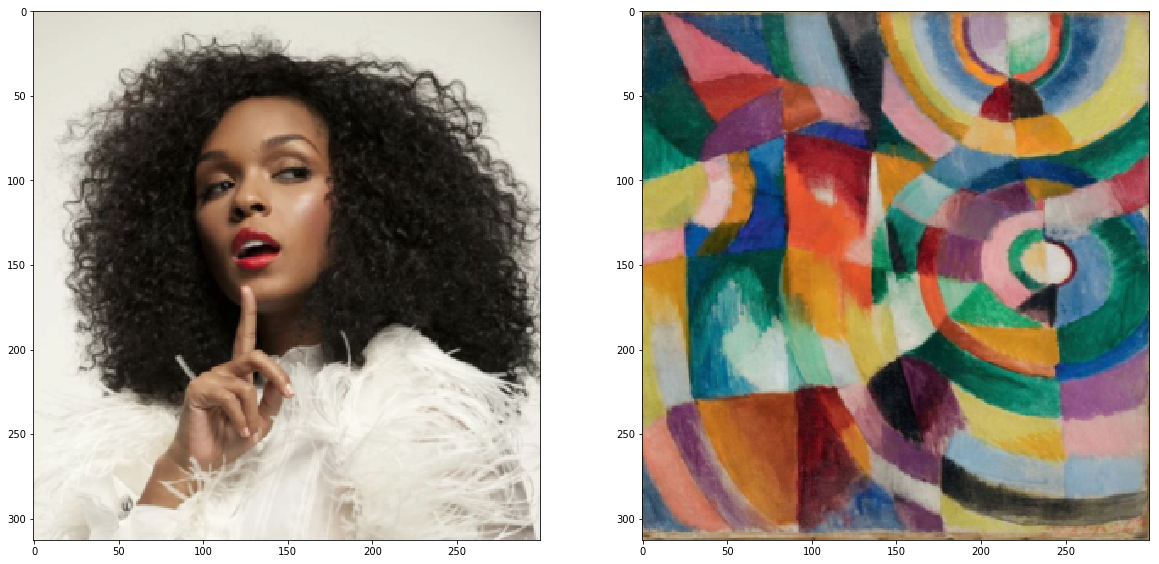

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))

### Load the pre-trained model

Load in the pretrained VGG19 network. This is not a traditional classification task, we only want this network to work as a feature extractor. So we get rid of the classifier part of the network. Also, we don't need to train the weights of the network, what we need to train instead is the pixel values on our new target image to make its content representation match the content representation of our content image and its style representation match the style representation of the style image.

In [27]:
vgg = models.vgg19(pretrained=True).features.to(device)

for param in vgg.parameters():
    param.requires_grad_(False)

### Feed Forward:

We passed in our images through the VGG19 network, but this time we want the outputs from specific layers. Therefore, the network is feeding forward layer by layer, and we saved the outputs from our six specified layers(5 for styles, and 1 for content) in a dictionary called representations.

In [28]:
def feature_extract(image_tensor, model):
    layers = {
        '0':'conv1_1',
        '5':'conv2_1',
        '10':'conv3_1',
        '19':'conv4_1',
        '21':'conv4_2',
        '28':'conv5_1'
    }
    x = image_tensor
    
    representations = {}
    #we go through the network layers one by one
    for layer in model._modules:
        x = model._modules[layer](x)
        if layer in layers.keys():
            representations[layers[layer]] = x
    return representations

### Gram Matrix:

Gram Matrix is essentially a correlation matrix, which measures the correlation between feature maps within one convolutional layer. If the correlation is high, it means that this feature is captured by lots of feature maps, which can be thought as part of the image's style. We want to compare the gram matrices of our style image and the gram matrices of our new target image, and try to minimize the difference between them during training. Based on the paper, we should have 5 gram matrices in total for the 5 style representation layers.

In [29]:
def correlation_mat(tensor):
    _, depth, _, _ = tensor.size()
    
    tensor = tensor.view(depth, -1) #shape: depth, height*width (batch_size=1)
    cor_mat = torch.matmul(tensor, tensor.t())
    return cor_mat

In [30]:
content_features = feature_extract(content_image, vgg)
style_features = feature_extract(style_image, vgg)

gram_matrix = {layer: correlation_mat(style_features[layer]) for layer in style_features.keys()}

### Target Image initialization

We initialize our target image by cloning our content image without any stylistic feature, and start to update it from there. 

In [31]:
target_image = content_image.clone().requires_grad_(True).to(device)

### Content loss and Style loss

Basically both losses are in the forms of mean squared error. For the content loss, it's just the mean squared difference between the content representation of content image and the content representation of the target image. For the Style loss, it's the weighted average of the mean squared difference between the gram matrix of the style image with that of the target image. 


The reason I said it's a weighted average is because we can assign different style weights for different layer's outputs, which will determines how much effect that layer's style will have on our final image. 


We add the style loss and content loss together to get the total loss. We usually find these two losses are very different from each other, but we would like to take both into account fairly equally. So we give each loss a weight, and usually the weight for style loss is much larger. However, when you give too much weight to style loss, the final image will be mostly styles without contents. If the weight is too low, the images will be contents without much stylistic effect.

In [32]:
style_weights = {
    'conv1_1': 1,
    'conv2_1': 0.8,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight = 1
style_weight = 1000

### Training

Here, we just use typical backpropogation and optimization to minimize the total loss by updating the parameters, which are the target image pixel values. We can take a look at the effect every 400 steps.

total loss:70636.140625


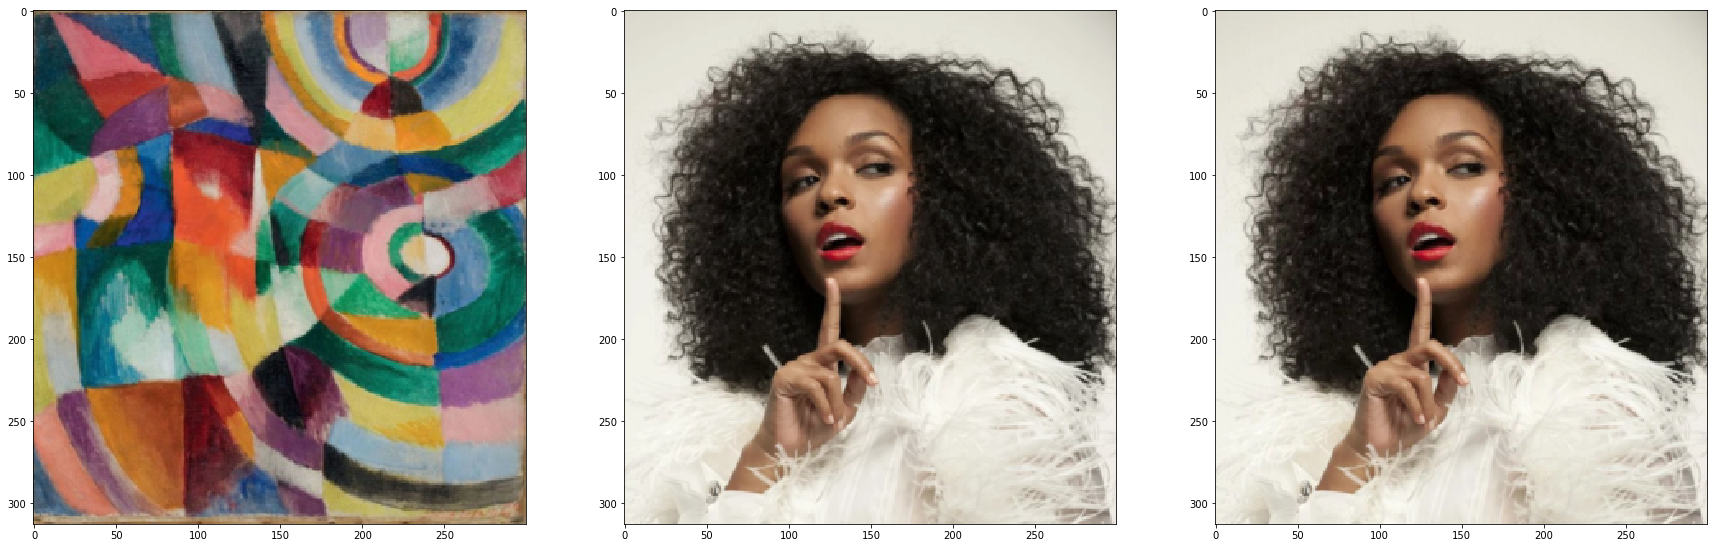

total loss:1902.8450927734375


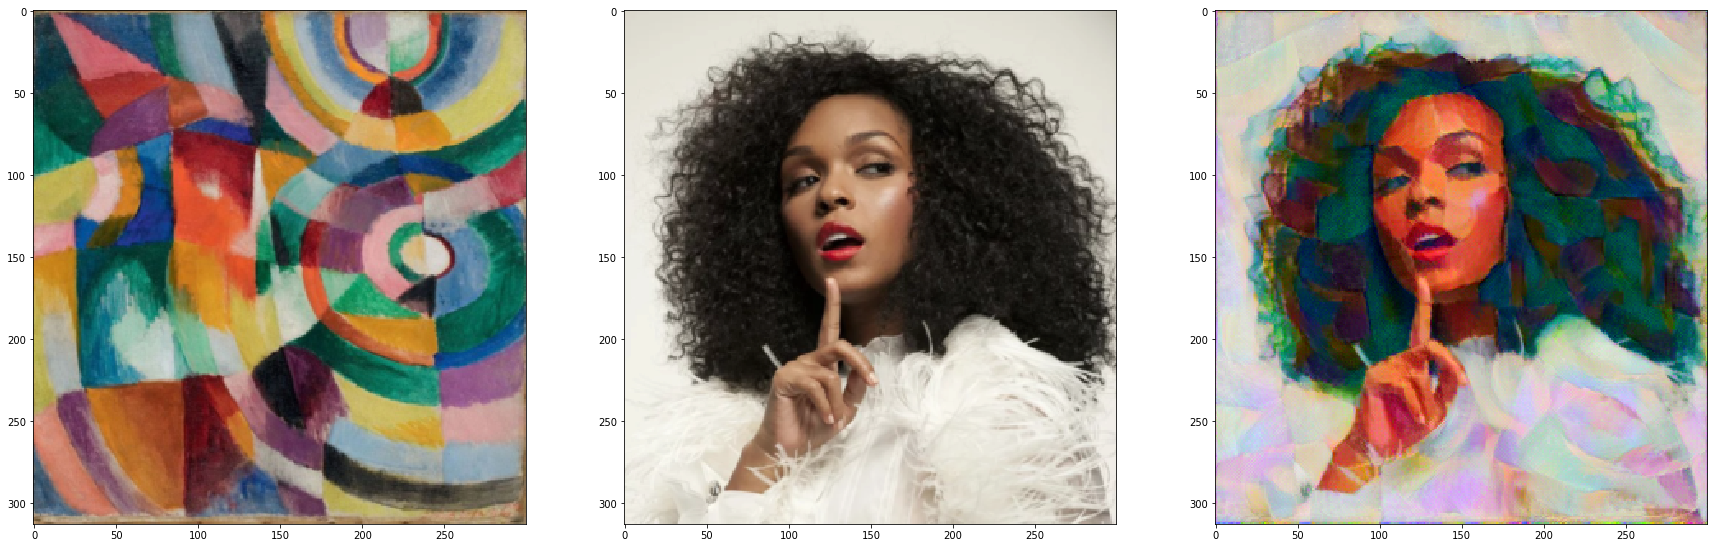

total loss:624.1941528320312


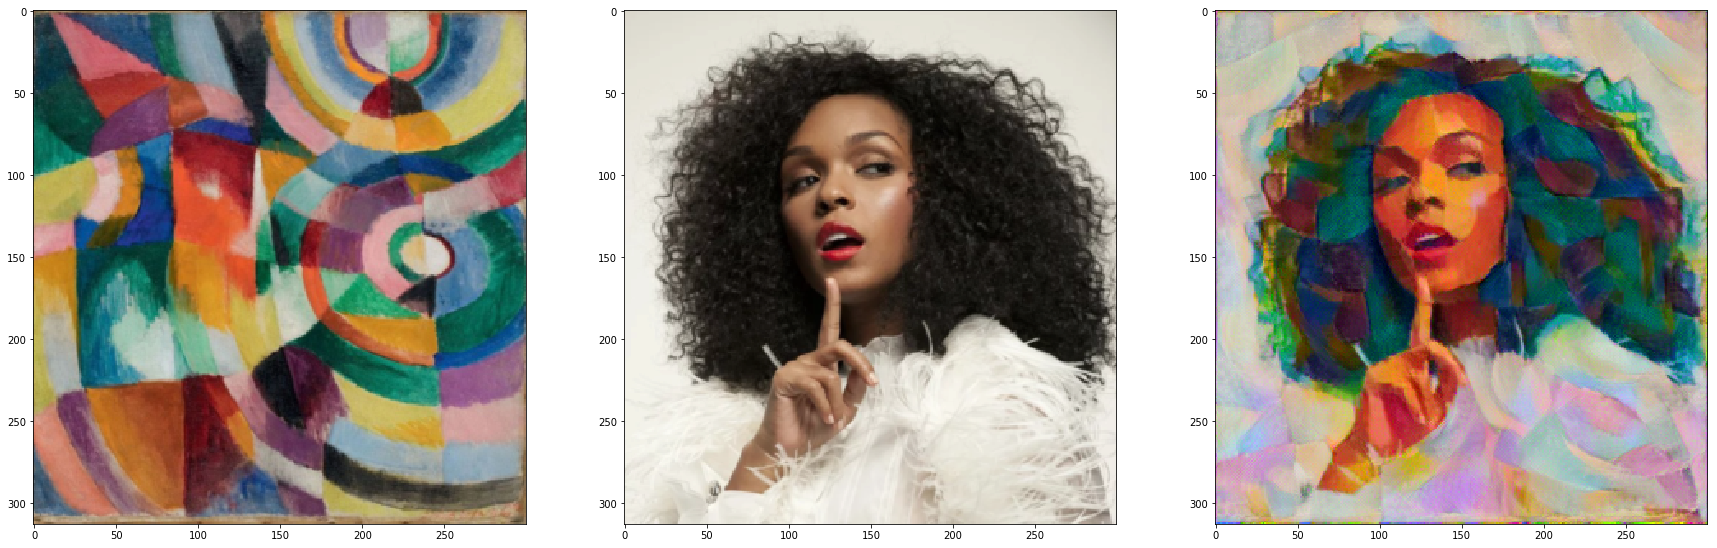

total loss:304.74249267578125


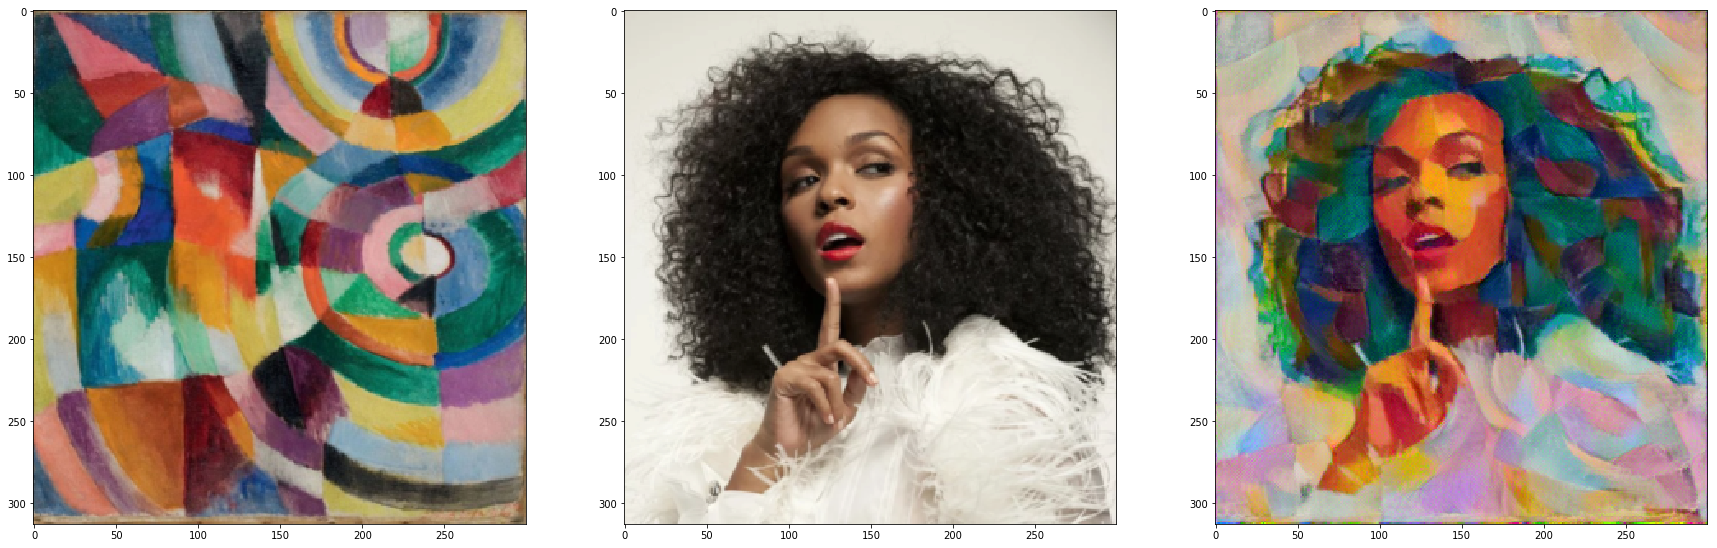

In [35]:
epoch = 1201
show_every = 400
optimizer = optim.Adam([target_image], lr=0.01)

for i in range(epoch):
    target_features = feature_extract(target_image, vgg)
    content_loss = torch.mean((content_features['conv4_2'] - target_features['conv4_2'])**2)

    style_loss = 0.0
    for layer in style_weights.keys():
        target_gram = correlation_mat(target_features[layer])
        style_gram = gram_matrix[layer]
        _, d, h, w = target_features[layer].shape
        layer_style_loss = style_weights[layer] * torch.mean((style_gram - target_gram)**2)
        style_loss += layer_style_loss/(d*h*w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % show_every == 0:
        print(f'total loss:{total_loss.item()}')
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
        ax1.imshow(im_convert(style_image))
        ax2.imshow(im_convert(content_image))
        ax3.imshow(im_convert(target_image))
        plt.show()